# Test PyCaret 3 Univariate Time Series Forecasting
Tobias Siegfried, 21/03/2023
This is based on the demo script provided at https://github.com/pycaret/pycaret/blob/master/tutorials/time_series/forecasting/univariate_without_exogeneous_part1.ipynb  

## Installation

In [1]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.9.13 (main, Oct 13 2022, 16:12:30)  [Clang 12.0.0 ]
executable: /Users/tobiassiegfried/opt/anaconda3/bin/python
   machine: macOS-10.16-x86_64-i386-64bit

PyCaret required dependencies:
                 pip: 22.3.1
          setuptools: 65.6.3
             pycaret: 3.0.0
             IPython: 8.10.0
          ipywidgets: 7.6.5
                tqdm: 4.64.1
               numpy: 1.21.5
              pandas: 1.4.4
              jinja2: 2.11.3
               scipy: 1.7.3
              joblib: 1.2.0
             sklearn: 1.0.2
                pyod: 1.0.9
            imblearn: 0.10.1
   category_encoders: 2.6.0
            lightgbm: 3.3.5
               numba: 0.56.4
            requests: 2.28.1
          matplotlib: 3.7.0
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.9.0
             kaleido: 0.2.1
         statsmodels: 0.13.5
              sktime: 0.16.1
               tbats: 1.1.2
            pmdarima: 2.0.3
              psutil: 5.9.

## Modules / Libraries
Next, we import modules.

In [2]:
import time
import numpy as np
import pandas as pd

from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

# Data
Load the data. Note, these data were prepared in the R project.
## Data Long

In [49]:
file_path = "./data_q_orig_long.csv"
data_long = pd.read_csv(filepath_or_buffer = file_path)
data_long.head(10)

,date,name,value
0,2001-01-31,q_17012,647.000000
1,2001-01-31,q_17084,202.443193
2,2001-01-31,q_16924,76.000000
3,2001-01-31,q_17461,58.100000
4,2001-01-31,q_16936,173.000000
5,2001-01-31,q_16938,63.161726
6,2001-02-28,q_17012,665.000000
7,2001-02-28,q_17084,186.274223
8,2001-02-28,q_16924,71.000000
9,2001-02-28,q_17461,56.000000


## Data Wide

In [50]:
data_wide = data_long.pivot(index = "date", columns = "name", values = "value")
data_wide.head(10)

name,q_16924,q_16936,q_16938,q_17012,q_17084,q_17461
date,,,,,,
2001-01-31,76.0,173.0,63.161726,647.0,202.443193,58.1
2001-02-28,71.0,169.0,66.163153,665.0,186.274223,56.0
2001-03-31,114.0,202.0,54.168812,753.0,222.651449,54.8
2001-04-30,261.0,329.0,98.275031,781.0,420.899531,59.6
2001-05-31,481.0,761.0,232.916244,1502.0,838.814554,150.0
2001-06-30,521.0,866.0,280.785869,3193.0,1452.804464,276.0
2001-07-31,288.0,645.0,103.306150,3087.0,1593.805586,255.0
2001-08-31,191.0,565.0,74.175338,2387.0,1197.600634,175.0
2001-09-30,133.0,377.0,61.161789,1289.0,517.773459,104.0


# Parameters & Figure Settings

In [52]:
fh = 12 # Forecast horizon
fold = 3 # number of cv folds

# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
fig_kwargs = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1500,
    "height": 800,
}

# Exploratory Data Analysis
For the time being, let us focus on one specific time series.

In [53]:
q_16936 = data_long[data_long['name'] == 'q_16936']
q_16936.drop('name', axis=1, inplace=True)
# Convert the 'date' column to datetime format
q_16936['date'] = pd.to_datetime(q_16936['date'], format='%Y-%m-%d')
q_16936.set_index('date', inplace=True)
q_16936 = q_16936.resample('M').mean()
q_16936_series = q_16936.squeeze()
q_16936_series
#type(q_16936)

date
2001-01-31    173.0
2001-02-28    169.0
2001-03-31    202.0
2001-04-30    329.0
2001-05-31    761.0
              ...  
2022-08-31    556.0
2022-09-30    356.0
2022-10-31    240.0
2022-11-30    235.0
2022-12-31    219.0
Freq: M, Name: value, Length: 264, dtype: float64

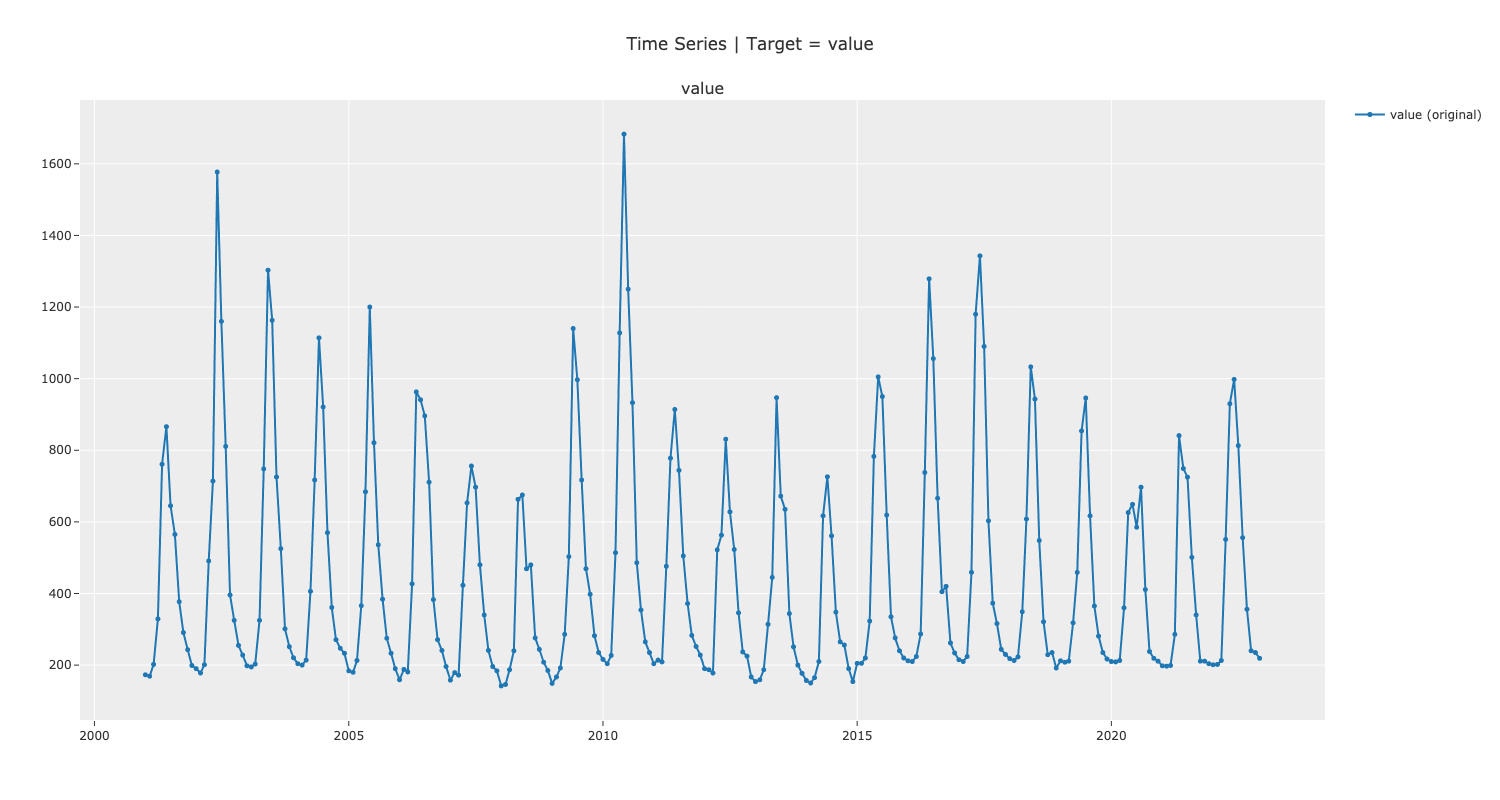

In [54]:
#eda = TSForecastingExperiment()
#eda.setup(data=series, fh=fh, fig_kwargs=fig_kwargs)
eda = TSForecastingExperiment()
eda.setup(data=q_16936_series, fh=fh, fig_kwargs=fig_kwargs)
eda.plot_model()

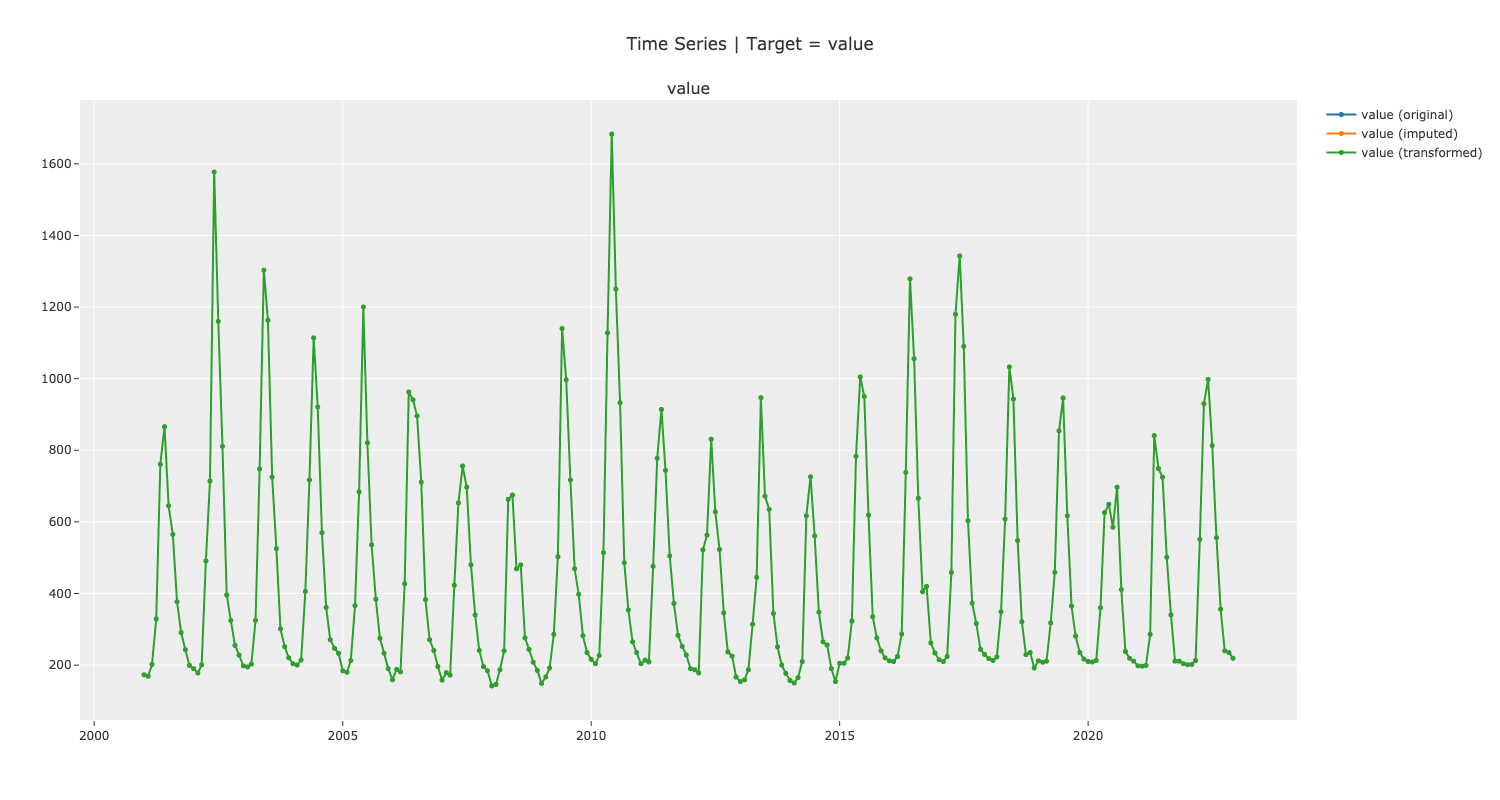

In [55]:
eda.plot_model(data_kwargs={"plot_data_type": ["original", "imputed", "transformed"]})

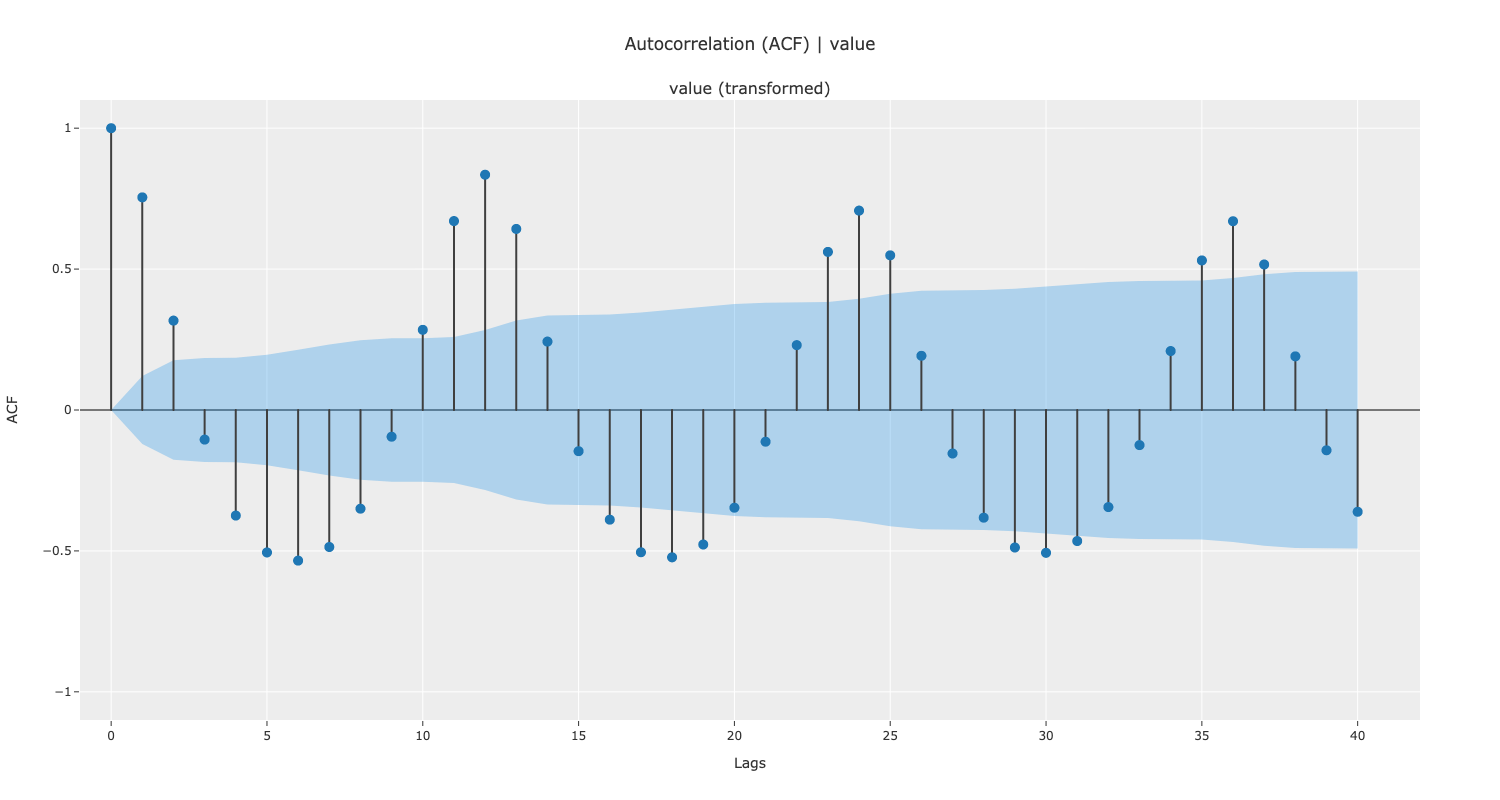

In [56]:
# ACF and PACF for the original dataset
eda.plot_model(plot="acf")

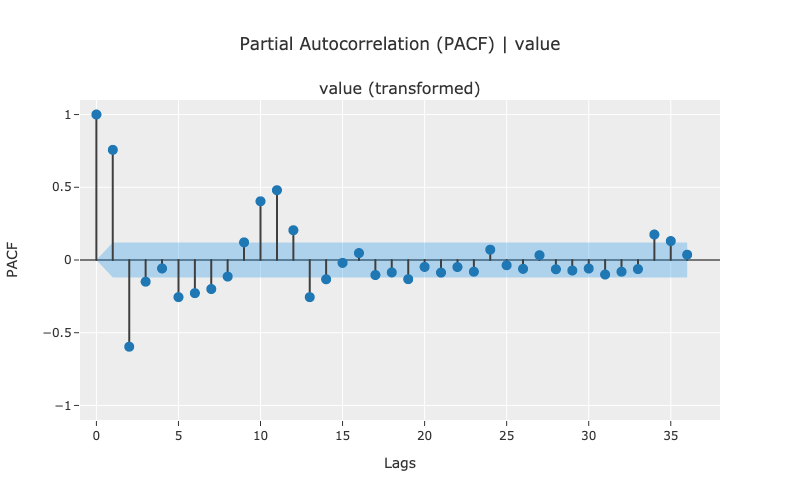

In [57]:
eda.plot_model(plot="pacf", data_kwargs={'nlags':36}, fig_kwargs={'height': 500, "width": 800})

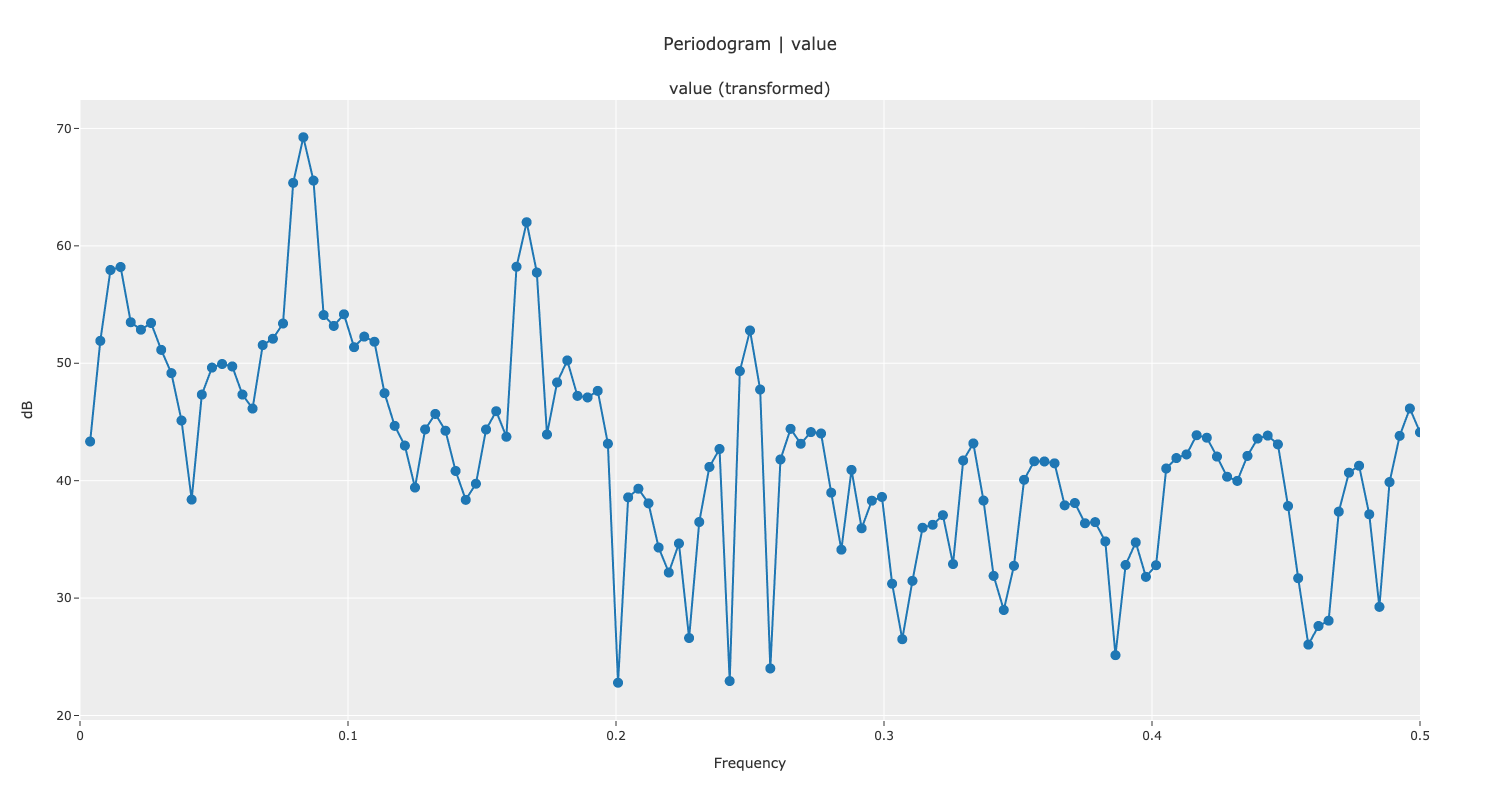

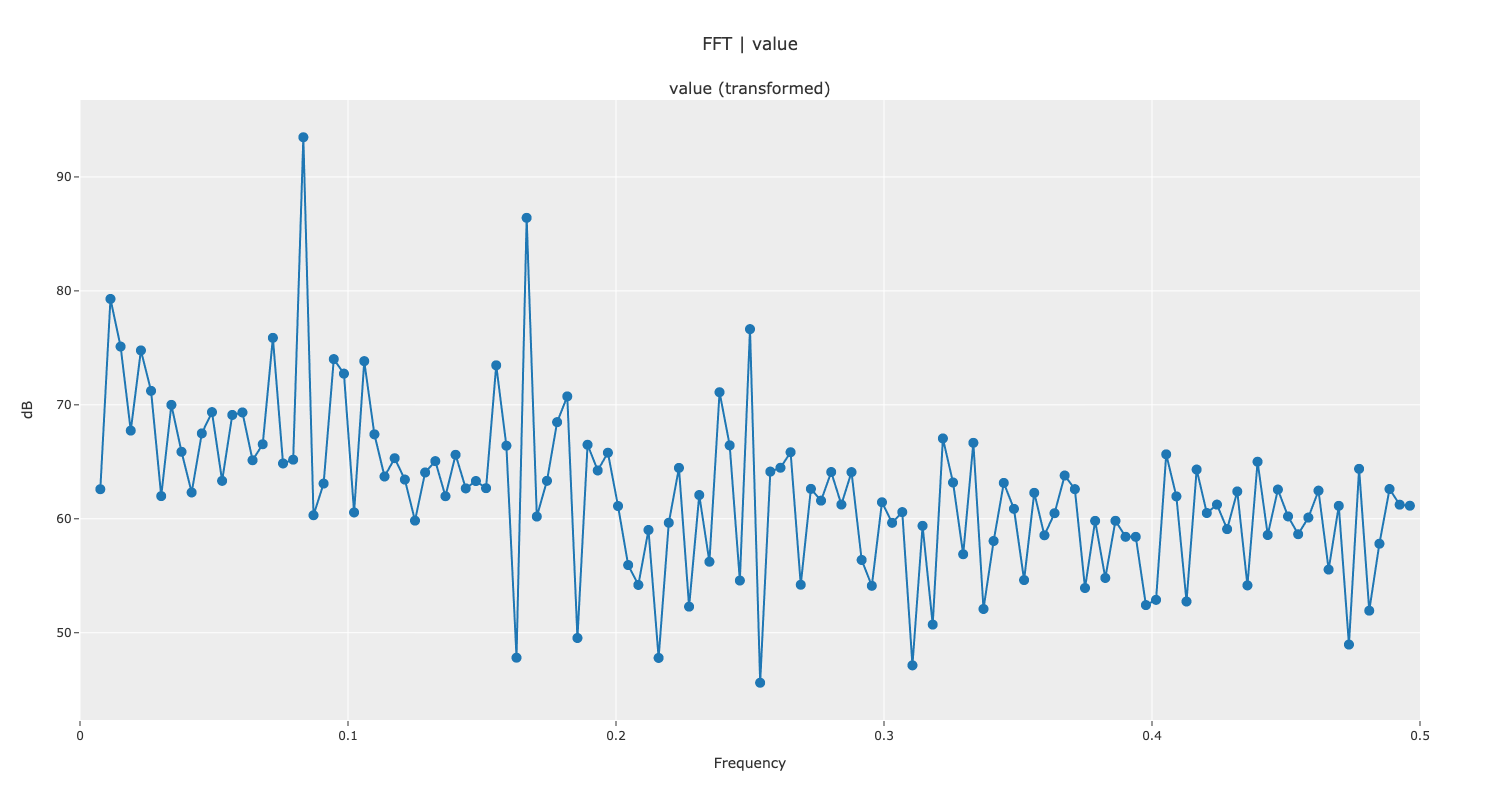

In [58]:
eda.plot_model(plot="periodogram")
eda.plot_model(plot="fft")

In the plots above, we notice
- Peaking at f = 0.0833, 0.1677, 0.25, 0.3333, 0.4167. All these are multiple of 0.0833. Hence 0.0833 is the fundamental frequency and the seasonal period is 1/0.0833 = 12.

Alternately, the diagnostics plot provides all these details in a convenient call.

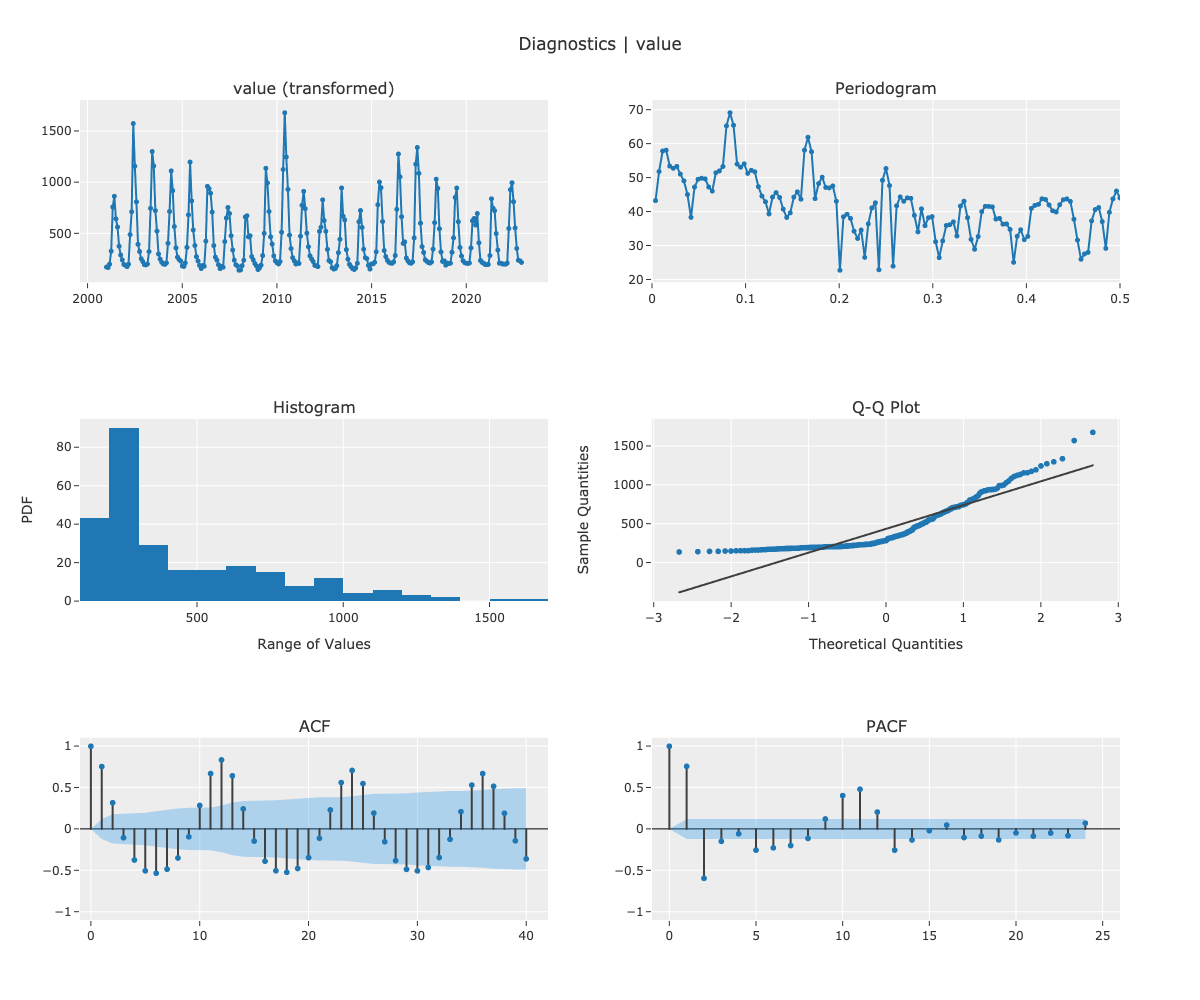

In [61]:
eda.plot_model(plot="diagnostics", fig_kwargs={"height": 1000, "width": 1200})

Our diagnostic plots indicated the need to difference and the presence of a seasonal period of 12. Let's see what happends when we remove this from the model. What other characteristics are left in the model that would need to be taken care of?
This can be achieved through the difference plots. Along with the difference plots, we will plot the corresponding ACF, PACF and Periodogram for further diagnostics.

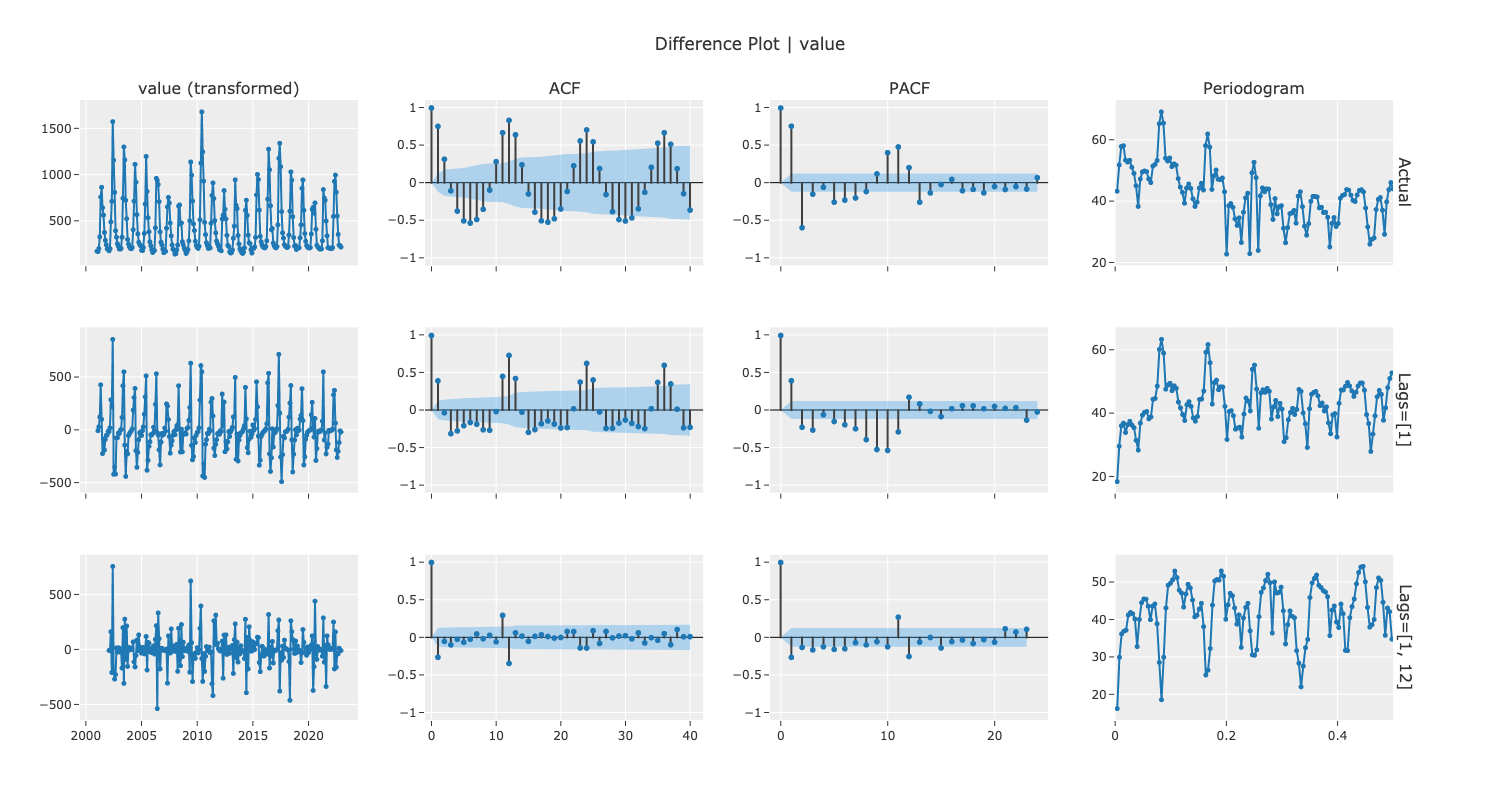

In [62]:
# Row 1: Original
# Row 2: d = 1
# Row 3: First (d = 1) then (D = 1, s = 12)
#   - Corresponds to applying a standard first difference to handle trend, and
#     followed by a seasonal difference (at lag 12) to attempt to account for
#     seasonal dependence.
# Ref: https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html
eda.plot_model(
    plot="diff",
    data_kwargs={"lags_list": [[1], [1, 12]], "acf": True, "pacf": True, "periodogram": True},
    fig_kwargs={"height": 800, "width": 1500}
)


# ## NOTE: Another way to specify differences is using order_list
# # Row 1: Original
# # Row 2: d = 1
# # Row 3: d = 2
# eda.plot_model(
#     plot="diff",
#     data_kwargs={
#         "order_list": [1, 2],
#         "acf": True, "pacf": True, "periodogram": True
#     },
#     fig_kwargs={"height": 600, "width": 1200}
# )

Observations:
In the second row, we have only removed the wandering behavior by taking a first difference. This can be seen in the ACF plot (extended autocorrelations are gone) and Periodogram (peaking at f =~ 0 is squished). The ACF (preaking at seasonal period of 12 and its multiples) and PACF (peaking at fundamental frequency of 0.0833 and its multiples) still show the seasonal behavior.
In the third row, we have taken first difference followed by a seasonal difference of 12. Now, we can see that the peaking at seasonal multiples is gone from both ACF and Periodogram. There is still a little bit of autoregresssive properties that we have not taken care of but by looking at the PACF, maybe p=1 seems like a reasonable value to use (most lags after that are insignificant).

Conclusion:
If you were modeling this with ARIMA, the model to try would be ARIMA(1,1,0)x(0,1,0,12).
Other models could use this information appropriately. For example, reduced regression models could remove the trend and seasonality of 12 (i.e. make the data stationary) before modeling the rest of the autoregressive properties. Luckily, the pycaret time series module will take care of this internally.

**Let's plot the Time Series Decomposition next (another classical diagnostic plot)**

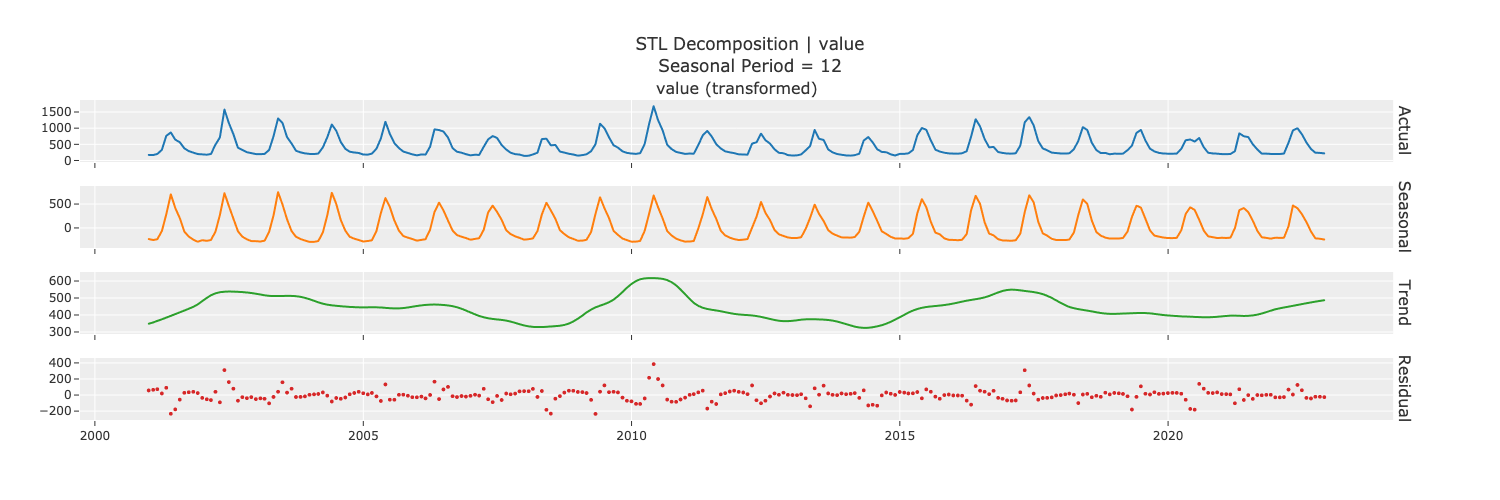

In [64]:
# STL Decomposition
# By default the seasonal period is the one detected during setup - 12 in this case.
eda.plot_model(plot="decomp_stl", fig_kwargs={"height": 500})

## Data Splitting
In time series, we can not split the data randomly since there is serial correlation in the data and using future data to predict past data will result in leakage. Hence, the temporal dependence must be maintained when splitting the data.

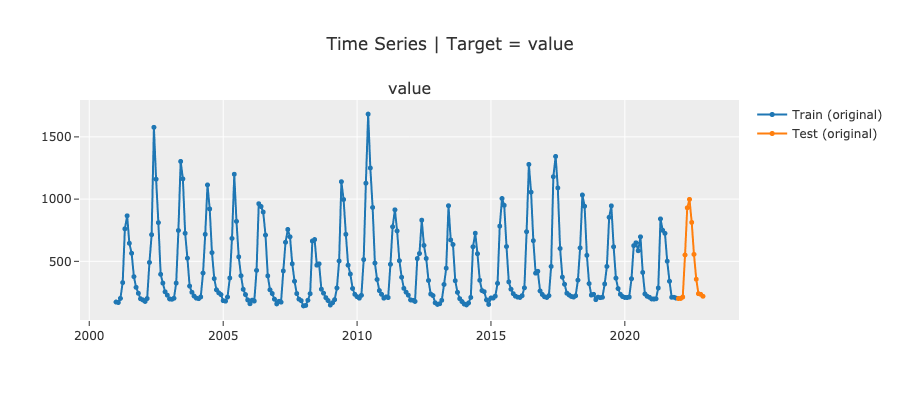

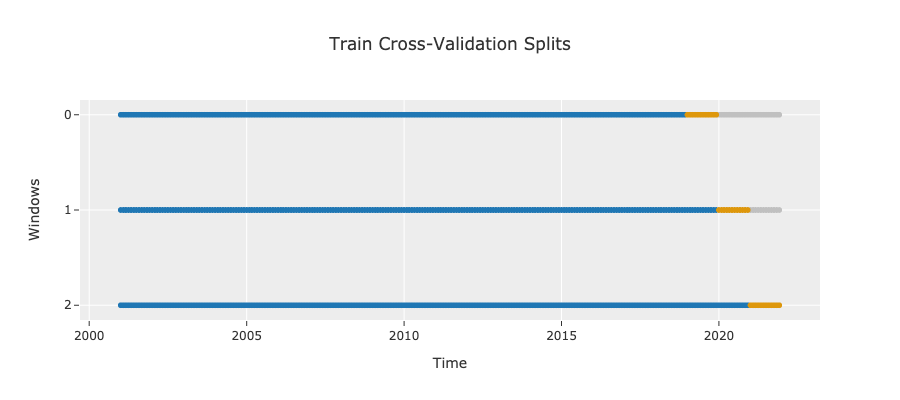

In [65]:
# Show the train-test splits on the dataset
# Internally split - len(fh) as test set, remaining used as test set
eda.plot_model(plot="train_test_split", fig_kwargs={"height": 400, "width": 900})

# Show the Cross Validation splits inside the train set
# The blue dots represent the training data for each fold.
# The orange dots represent the validation data for each fold
eda.plot_model(plot="cv", fig_kwargs={"height": 400, "width": 900})

```
# This is formatted as code
```

# Statistical Tests

Statistical Testing is another important part of time series modeling. This can be achieved easily in pycaret using `check_stats`.

**Options are:**
* 'summary',
* 'white_noise'
* 'stationarity'
* 'adf'
* 'kpss'
* 'normality'
* 'all' 

By default the statistics are run on the "transformed" data, but similar to plots, the user has the abiliy to set this to another data type using the `data_type` argument. e.g. `eda.check_stats(test="summary", data_type = "original")`

In [66]:
# Summary Statistics
eda.check_stats(test="summary")

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,264.000000
1,Summary,Statistics,Transformed,# Missing Values,,0.000000
2,Summary,Statistics,Transformed,Mean,,439.280082
3,Summary,Statistics,Transformed,Median,,289.000000
4,Summary,Statistics,Transformed,Standard Deviation,,306.826243
5,Summary,Statistics,Transformed,Variance,,94142.343292
6,Summary,Statistics,Transformed,Kurtosis,,1.450416
7,Summary,Statistics,Transformed,Skewness,,1.387590
8,Summary,Statistics,Transformed,# Distinct Values,,206.000000


In [67]:
# Stationarity tests (ADF and KPSS)
# NOTE: Users can also just run a single test by passing either 'adf' or 'kpss' to `check_stats`
eda.check_stats(test='stationarity')

,Test,Test Name,Data,Property,Setting,Value
0,Stationarity,ADF,Transformed,Stationarity,{'alpha': 0.05},True
1,Stationarity,ADF,Transformed,p-value,{'alpha': 0.05},0.036498
2,Stationarity,ADF,Transformed,Test Statistic,{'alpha': 0.05},-2.98315
3,Stationarity,ADF,Transformed,Critical Value 1%,{'alpha': 0.05},-3.456781
4,Stationarity,ADF,Transformed,Critical Value 5%,{'alpha': 0.05},-2.873172
5,Stationarity,ADF,Transformed,Critical Value 10%,{'alpha': 0.05},-2.572969
6,Stationarity,KPSS,Transformed,Trend Stationarity,{'alpha': 0.05},True
7,Stationarity,KPSS,Transformed,p-value,{'alpha': 0.05},0.1
8,Stationarity,KPSS,Transformed,Test Statistic,{'alpha': 0.05},0.019286
9,Stationarity,KPSS,Transformed,Critical Value 10%,{'alpha': 0.05},0.119


The ADF tests shows that the data is stationary.

In [68]:
# Ljung-Bx test to tests of white noise (whether the data is uncorrelated or not)
eda.check_stats(test='white_noise')

,Test,Test Name,Data,Property,Setting,Value
0,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",1497.431349
1,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 48}",2755.702291
2,White Noise,Ljung-Box,Transformed,p-value,"{'alpha': 0.05, 'K': 24}",0.0
3,White Noise,Ljung-Box,Transformed,p-value,"{'alpha': 0.05, 'K': 48}",0.0
4,White Noise,Ljung-Box,Transformed,White Noise,"{'alpha': 0.05, 'K': 24}",False
5,White Noise,Ljung-Box,Transformed,White Noise,"{'alpha': 0.05, 'K': 48}",False


The Ljung-Box tests indicates that the data is not white noise. Now, finally the command below alows to perform all tests together.

In [69]:
eda.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,264.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,439.280082
3,Summary,Statistics,Transformed,Median,,289.0
4,Summary,Statistics,Transformed,Standard Deviation,,306.826243
5,Summary,Statistics,Transformed,Variance,,94142.343292
6,Summary,Statistics,Transformed,Kurtosis,,1.450416
7,Summary,Statistics,Transformed,Skewness,,1.38759
8,Summary,Statistics,Transformed,# Distinct Values,,206.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",1497.431349


# Model Data

In [71]:
exp = TSForecastingExperiment()
exp.setup(data=q_16936_series, fh=fh, fig_kwargs=fig_kwargs)

## Check available models

In [72]:
exp.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend.PolynomialTrendForeca...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
croston,Croston,sktime.forecasting.croston.Croston,True
ets,ETS,sktime.forecasting.ets.AutoETS,True


We have so many models! How do we know which one is the best?

In [80]:
exp = TSForecastingExperiment()
exp.setup(data=q_16936_series, fh=fh, fold=fold, fig_kwargs=fig_kwargs, session_id=42)

In [81]:
# Get the 3 best baseline models 
best_baseline_models = exp.compare_models(n_select=3)
best_baseline_models

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:56:39
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Naive Forecaster


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
snaive,Seasonal Naive Forecaster,0.7010,0.6183,67.2778,103.1588,0.1377,0.1312,0.7466,0.0067
arima,ARIMA,0.7027,0.6175,67.4476,103.0260,0.1390,0.1326,0.7466,0.0300
auto_arima,Auto ARIMA,0.7264,0.6684,69.8204,111.7396,0.1461,0.1310,0.7088,2.7667
theta,Theta Forecaster,0.7513,0.6697,72.2582,111.8519,0.1531,0.1420,0.6979,0.0100
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7670,0.7161,73.7441,119.6680,0.1548,0.1421,0.6735,0.0767
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.7706,0.7204,74.0969,120.3840,0.1548,0.1418,0.6693,0.0733
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.7928,0.7190,76.2342,120.1731,0.1637,0.1545,0.6672,0.0767
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.7981,0.7331,76.7211,122.4818,0.1653,0.1555,0.6436,0.0900
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8057,0.7313,77.4426,122.2159,0.1665,0.1567,0.6568,0.0767
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8132,0.7385,78.1613,123.4096,0.1680,0.1582,0.6494,0.0767


[NaiveForecaster(sp=12),
 ARIMA(seasonal_order=(0, 1, 0, 12)),
 AutoARIMA(random_state=42, sp=12, suppress_warnings=True)]

In [82]:
# We will save the metrics to be used in a later step.
compare_metrics = exp.pull()
# compare_metrics

## Tune Best Models

In [83]:
best_tuned_models = [exp.tune_model(model) for model in best_baseline_models]
best_tuned_models

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:57:45
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Seasonal Naive Forecaster


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2018-12,0.4869,0.4335,47.9167,73.8484,0.1064,0.1038,0.9121
1,2019-12,0.8463,0.7997,80.9167,133.1243,0.1541,0.1420,0.5134
2,2020-12,0.7697,0.6217,73.0000,102.5037,0.1528,0.1477,0.8144
Mean,NaT,0.7010,0.6183,67.2778,103.1588,0.1377,0.1312,0.7466
SD,NaT,0.1546,0.1495,14.0667,24.2037,0.0222,0.0195,0.1697


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:57:45
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,ARIMA


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2018-12,0.4844,0.4299,47.6721,73.2345,0.1067,0.1045,0.9135
1,2019-12,0.8652,0.8013,82.7299,133.3886,0.1636,0.1507,0.5115
2,2020-12,0.7607,0.6218,72.1491,102.5169,0.1481,0.1435,0.8144
Mean,NaT,0.7035,0.6176,67.5170,103.0467,0.1395,0.1329,0.7465
SD,NaT,0.1607,0.1516,14.6823,24.5607,0.0240,0.0203,0.1710


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:57:49
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Auto ARIMA


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2018-12,0.5564,0.5375,54.7581,91.5655,0.1123,0.1013,0.8648
1,2019-12,0.8290,0.7687,79.2621,127.9698,0.1595,0.1438,0.5504
2,2020-12,0.7876,0.6415,74.6960,105.7707,0.1820,0.1617,0.8024
Mean,NaT,0.7243,0.6492,69.5721,108.4353,0.1513,0.1356,0.7392
SD,NaT,0.1200,0.0946,10.6397,14.9809,0.0291,0.0253,0.1359


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[NaiveForecaster(sp=12),
 ARIMA(seasonal_order=(0, 1, 0, 12)),
 AutoARIMA(max_order=None, max_p=12, max_q=12, random_state=42, sp=24,
           suppress_warnings=True)]

## Blend Best Models

We can achieve even better results sometimes if we combine results of several good models. This can be achieved using the blend_model functionality. There are several options such as the mean blender, 'median blender or the voting blender.

The mean and median blenders takes the mean and median (respectively) of all individual model forecasts and uses that as the final forecast. The voting blender will combine the individual forecasts per the weights provided by the user.

In [84]:
# Get model weights to use
top_model_metrics = compare_metrics.iloc[0:3]['MAE']
display(top_model_metrics)

top_model_weights = 1 - top_model_metrics/top_model_metrics.sum()
display(top_model_weights)

snaive        67.2778
arima         67.4476
auto_arima    69.8204
Name: MAE, dtype: object

snaive        0.671087
arima         0.670257
auto_arima    0.658656
Name: MAE, dtype: object

In [85]:
blender = exp.blend_models(best_tuned_models, method='voting', weights=top_model_weights.values.tolist())


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:18:36
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,EnsembleForecaster


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2018-12,0.4872,0.4457,47.9537,75.9302,0.1000,0.0939,0.9070
1,2019-12,0.8052,0.7492,76.9868,124.7186,0.1493,0.1352,0.5729
2,2020-12,0.5754,0.4615,54.5717,76.0931,0.1354,0.1269,0.8977
Mean,NaT,0.6226,0.5521,59.8374,92.2473,0.1282,0.1187,0.7926
SD,NaT,0.1340,0.1395,12.4238,22.9608,0.0208,0.0178,0.1554


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,EnsembleForecaster,0.6590,0.6402,61.7781,103.9250,0.0942,0.1084,0.8723


           y_pred
2022-01  197.8434
2022-02  199.3344
2022-03  205.4071
2022-04  308.4418
2022-05  778.0356
2022-06  796.2260
2022-07  735.1778
2022-08  532.1843
2022-09  350.3541
2022-10  236.5765
2022-11  223.1530
2022-12  209.9287


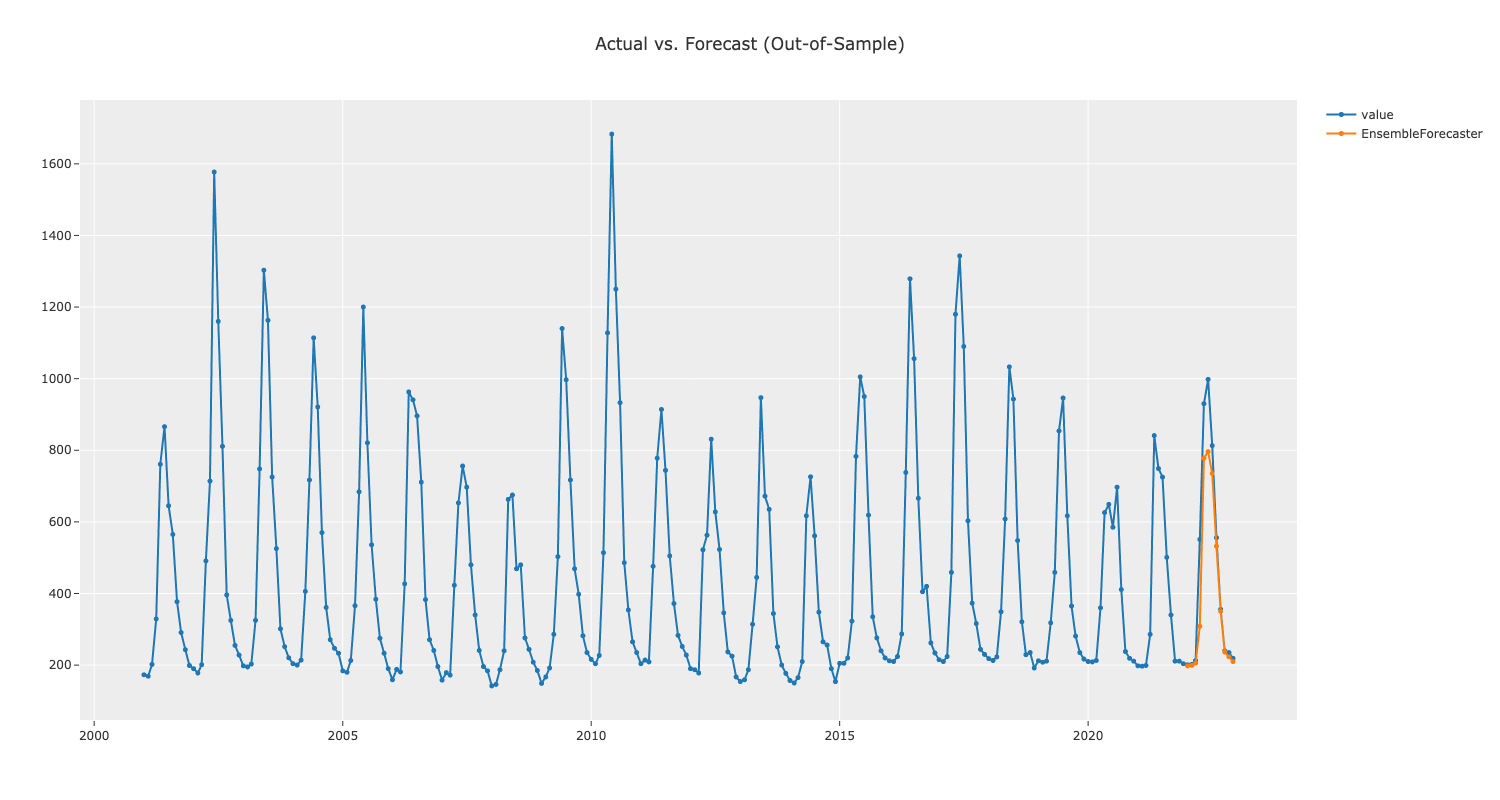

In [86]:
q_predict = exp.predict_model(blender)
print(q_predict)
exp.plot_model(estimator=blender)

This forecast looks meaningful since the model just predicts the mean summer discharge as it has no other information that could help him scale the summer peak in relation to the characteristics of the snowpack present.

# Finalize Model

           y_pred
2023-01  210.2137
2023-02  209.5072
2023-03  218.9591
2023-04  487.1434
2023-05  852.5754
2023-06  972.0378
2023-07  824.7657
2023-08  561.0707
2023-09  359.3389
2023-10  256.3394
2023-11  239.8202
2023-12  223.7572


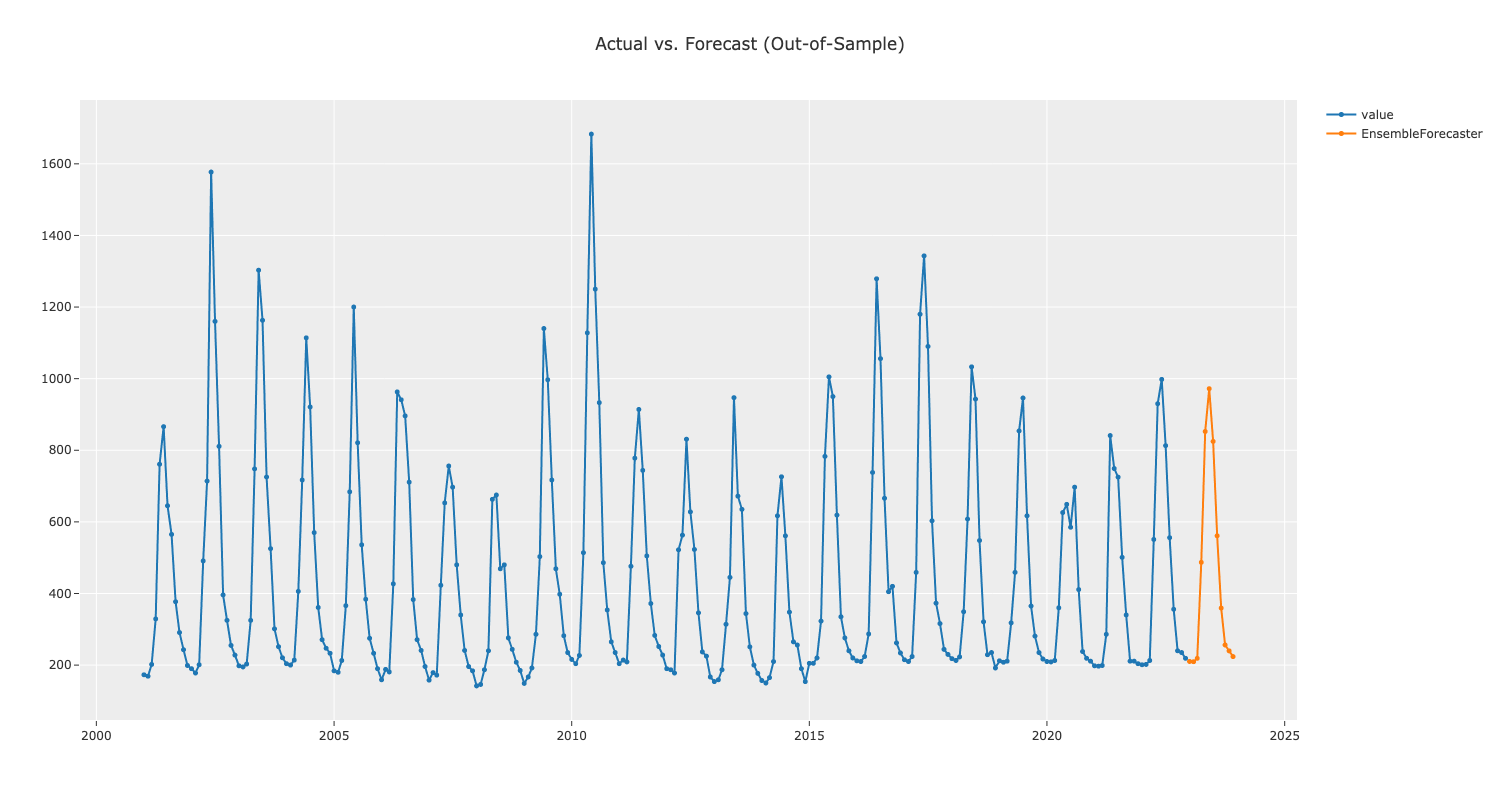

In [87]:
final_model = exp.finalize_model(blender)
print(exp.predict_model(final_model))
exp.plot_model(final_model)

# Save and Load Model

In [ ]:
_ = exp.save_model(final_model, "my_blender")


In [ ]:
loaded_exp = TSForecastingExperiment()
m = loaded_exp.load_model("my_blender")
# Predictions should be same as before the model was saved and loaded
loaded_exp.predict_model(m)